In [47]:
import pandas as pd
import numpy as np
from pydantic import BaseModel, Field, ValidationError, validator
import matplotlib.pyplot as plt
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

In [105]:
class GBMsimulator(BaseModel):

    S0: float = Field(..., gt=0, description="Initial stock price")
    E: float = Field(..., gt=0, alias="strike", description="Strike price")
    mu: float = Field(..., ge=0, le=1, alias="rate", description="rate")
    sigma: float = Field(..., gt=0, le=1, description="Volatility")
    T: int = Field(..., gt=0, le=3650, alias="dates", description="Days to expiration")
    N_paths: int = Field(..., gt=0, alias="npaths", description="Number of simulations")
    n_steps: int = Field(252, gt=0, alias="timesteps", description="Number of timesteps")
    scheme: str =  Field(...,description="simulationscheme")

    class Config:
        allow_population_by_field_name = True

     
        
    @property
    def pseudorandomnumber(self) -> np.ndarray:
        return np.random.standard_normal(self.N_paths)

    @property
    def pathsimulation(self) -> np.ndarray:
        
        np.random.seed(2025)

        dt = self.T / self.n_steps

        S = np.zeros((self.n_steps, self.N_paths))
        S[0] = self.S0

        for i in range(0, self.n_steps-1):
            w = self.pseudorandomnumber

            if self.scheme == 'euler':
                S[i+1,:] = S[i,:] * (1 + self.mu*dt + self.sigma*np.sqrt(dt)*w)

            elif self.scheme == 'milstein':
                S[i+1,:] = S[i,:] * (1 + self.mu*dt + self.sigma*np.sqrt(dt)*w + 0.5*self.sigma**2*dt*(w**2-1))

            else:
                raise ValueError(f"Unknown scheme: {self.scheme}. Use 'euler' or 'milstein'.")

        return S

#shape of w:(N_paths,),1D NumPy array, a sequence of numbers
#each row represents a time step,and each column represents a simulation path 




In [99]:
eulerscheme =  GBMsimulator(
                S0=100,
                strike=100,
                rate=0.05,
                sigma=0.2,
                dates=1,
                npaths=100000,
                n_steps=252,
                scheme='euler'
        )

In [101]:
eulerpath = eulerscheme.pathsimulation

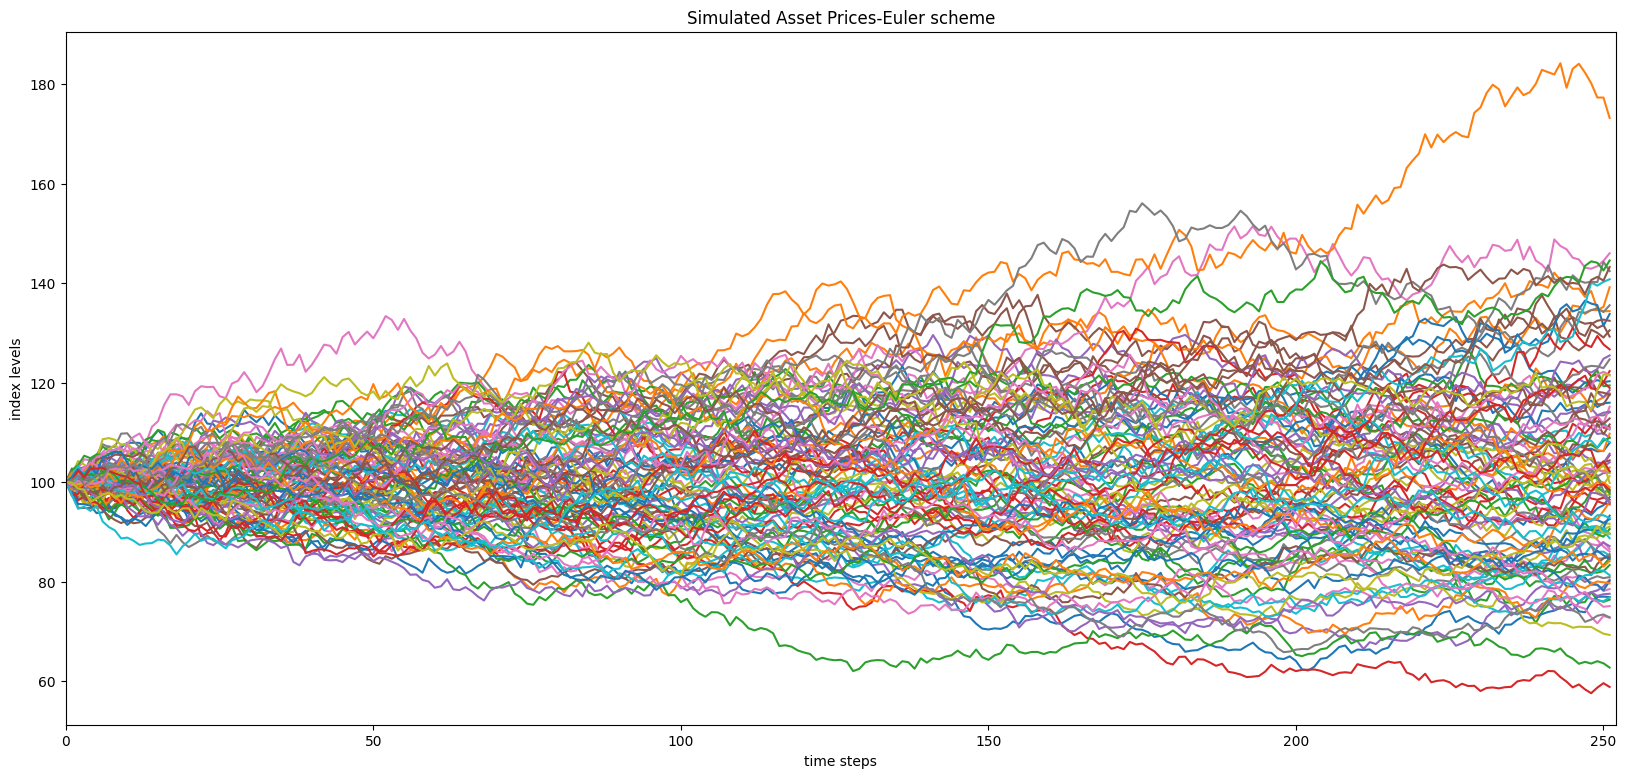

In [103]:
plt.figure(figsize=(20,9))
plt.plot(eulerscheme.pathsimulation[:,:100])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('index levels')
plt.title('Simulated Asset Prices-Euler scheme');

In [131]:
pd.DataFrame(eulerscheme.pathsimulation).head(10)

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,99.903441,100.944954,98.207020,99.184008,99.892936,102.724790,101.775748,99.758578,100.981871,100.278185,...,99.613474,101.845737,100.902556,101.123928,100.150958,100.125869,99.244602,102.528947,98.674810,100.180191
2,99.345214,101.821660,98.723040,98.018993,98.590876,100.206093,102.780763,100.825784,99.375341,101.584694,...,101.978604,102.259856,101.782055,99.808803,101.683364,98.076991,99.104893,106.595556,98.097037,100.064025
3,100.998181,99.599020,98.790151,99.624174,100.366497,98.660929,104.576009,101.014763,97.242001,100.591981,...,101.005549,101.559175,103.727754,102.179913,101.507059,100.612370,99.786156,105.829691,96.198639,100.832572
4,100.988982,100.433012,98.781391,101.429466,100.558523,100.081110,104.385652,101.268674,96.429088,100.041747,...,103.980785,99.045037,104.456082,102.287960,102.839965,100.304590,100.911626,106.214315,97.059590,101.301550
5,103.464294,98.015576,98.086764,99.988757,99.437191,99.884181,102.386550,102.280005,95.766778,100.827509,...,104.928523,96.871020,104.872966,100.345709,103.716821,99.937867,101.757268,107.038998,97.711032,101.869441
6,102.730176,98.601878,97.779183,98.690837,102.064075,102.938118,100.532175,102.845317,95.833478,100.313841,...,107.113996,94.613062,105.187188,101.602260,103.725524,99.876499,100.263662,110.327035,98.725825,103.910054
7,104.205927,98.021905,98.249792,98.639223,103.121152,103.055540,101.154837,102.712951,95.888433,102.036739,...,106.091639,94.827552,106.415011,101.596302,104.877686,99.947356,102.218795,109.890364,96.365790,102.853674
8,106.505852,100.194612,96.614897,100.676514,103.290322,102.444062,99.495360,102.315597,96.671381,102.781888,...,107.020981,93.378830,106.563264,102.160840,104.353171,101.128290,104.410356,109.633119,96.090666,104.779375
9,106.964737,100.608673,98.178470,103.318578,100.517319,100.845940,100.206517,101.117185,96.827428,103.765432,...,107.113230,93.775079,107.244389,101.089246,104.900079,103.246025,103.616874,110.701152,95.764616,104.828677


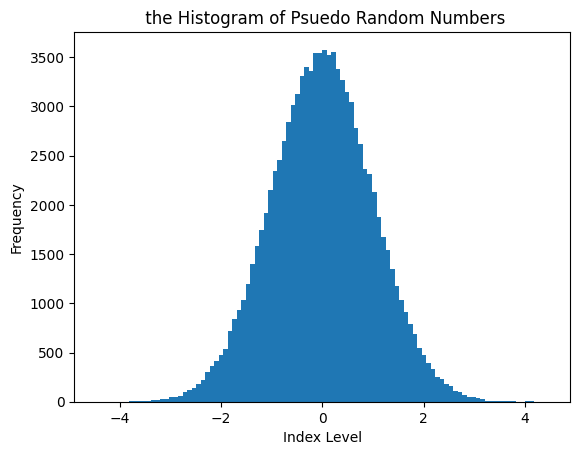

In [137]:
pseudorandom = eulerscheme.pseudorandomnumber
plt.hist(pseudorandom.flatten(), bins=100)
plt.title(' the Histogram of Psuedo Random Numbers')
plt.xlabel('Index Level')
plt.ylabel('Frequency')
plt.show()

In [139]:
pseudorandom.mean(), pseudorandom.std()

(-0.005543773317243638, 1.0019601254713244)

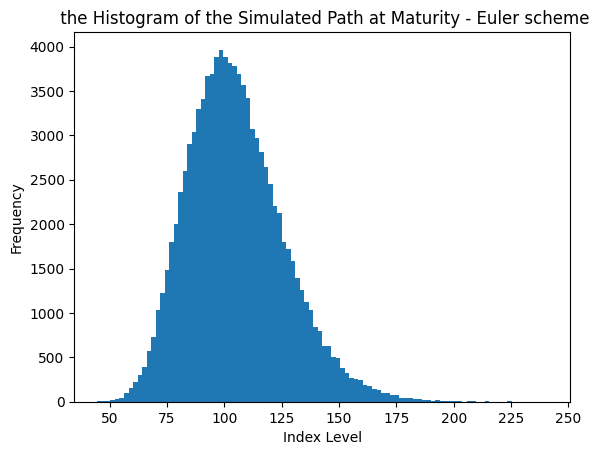

In [143]:
plt.hist(eulerscheme.pathsimulation[-1,:], bins=100)
plt.title(' the Histogram of the Simulated Path at Maturity - Euler scheme')
plt.xlabel('Index Level')
plt.ylabel('Frequency')
plt.show()

In [107]:
milsteinscheme =  GBMsimulator(
                S0=100,
                strike=100,
                rate=0.05,
                sigma=0.2,
                dates=1,
                npaths=100000,
                n_steps=252,
                scheme='milstein'
        )

In [109]:
milsteinpath = milsteinscheme.pathsimulation

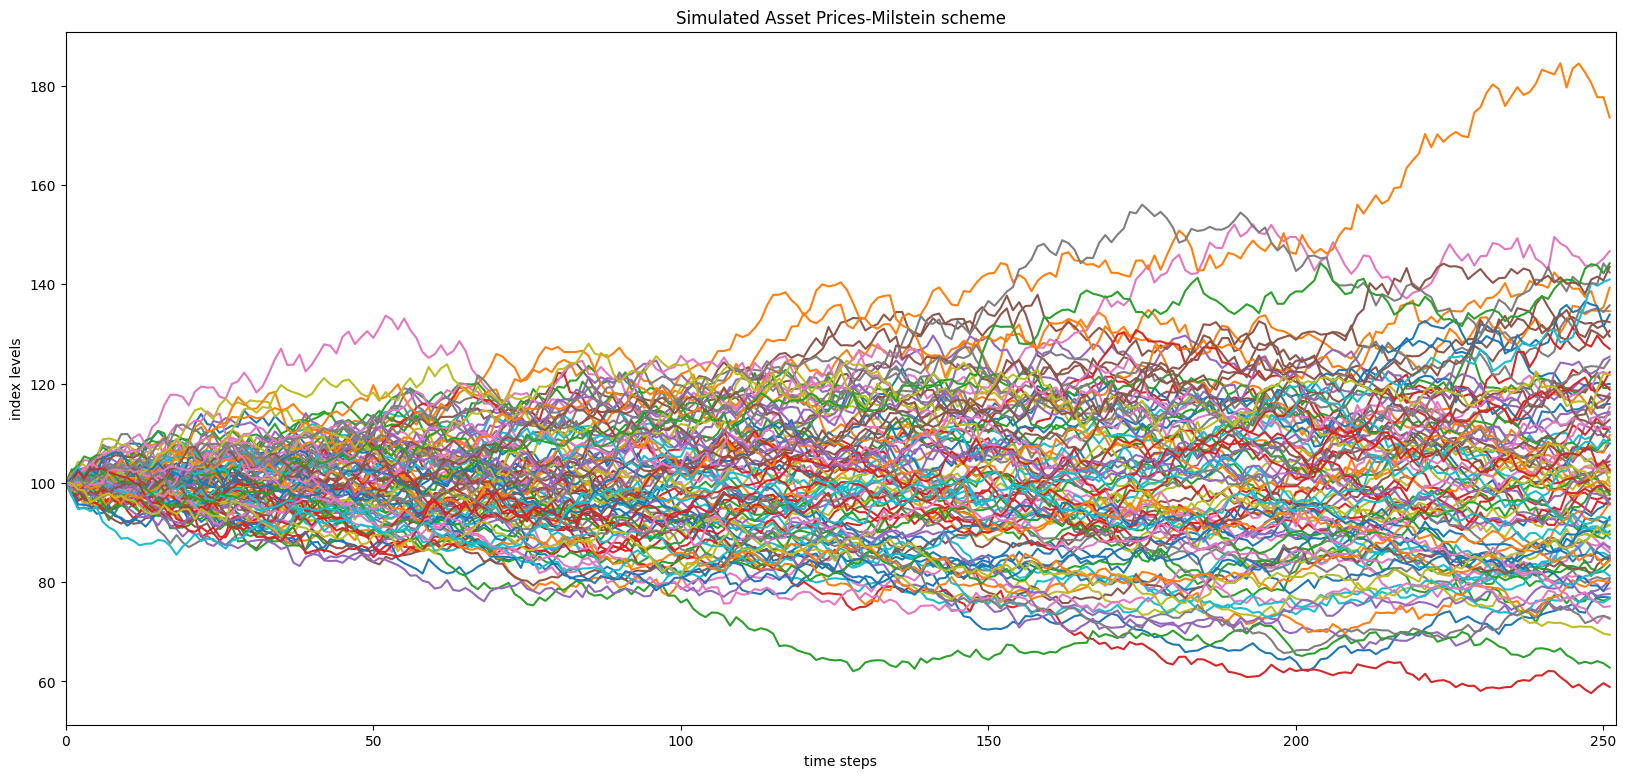

In [111]:
plt.figure(figsize=(20,9))
plt.plot(milsteinscheme.pathsimulation[:,:100])
plt.xlabel('time steps')
plt.xlim(0,252)
plt.ylabel('index levels')
plt.title('Simulated Asset Prices-Milstein scheme');

In [115]:
pd.DataFrame(milsteinscheme.pathsimulation).head(10)

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,99.895572,100.941297,98.215515,99.179565,99.885080,102.753437,101.783228,99.750983,100.978562,100.270582,...,99.606363,101.854470,100.898515,101.122086,100.143108,100.117988,99.239670,102.552489,98.675919,100.172383
2,99.331134,101.813595,98.725040,98.013805,98.583941,100.257271,102.785003,100.815689,99.377170,101.577288,...,101.991028,102.261303,101.773632,99.807774,101.678867,98.082696,99.092220,106.691752,98.092116,100.048369
3,100.989406,99.607750,98.784329,99.623949,100.367251,98.715589,104.587491,100.996790,97.259228,100.581634,...,101.014597,101.555038,103.729304,102.198634,101.494689,100.642710,99.767740,105.919637,96.204775,100.811655
4,100.972197,100.437239,98.767733,101.437331,100.551460,100.138669,104.389026,101.242910,96.442014,100.025090,...,104.025318,99.064561,104.451825,102.298628,102.827865,100.327384,100.891209,106.296806,97.061829,101.273534
5,103.468926,98.041307,98.067945,99.998980,99.428702,99.933915,102.401116,102.250799,95.774369,100.805714,...,104.969340,96.906550,104.861154,100.366885,103.700023,99.953360,101.732049,107.116736,97.707642,101.834712
6,102.729316,98.621620,97.753186,98.701675,102.081646,103.027546,100.555515,102.809286,95.833485,100.285569,...,107.169670,94.666848,105.167428,101.623357,103.700495,99.884083,100.241996,110.448547,98.719715,103.886575
7,104.207210,98.035528,98.216951,98.642248,103.136071,103.136940,101.172148,102.668920,95.880841,102.014473,...,106.143362,94.874150,106.393597,101.609335,104.850319,99.947031,102.207423,110.003583,96.380669,102.827769
8,106.523820,100.224409,96.588732,100.692410,103.297188,102.518732,99.518304,102.264437,96.659160,102.753938,...,107.068624,93.428547,106.533452,102.167341,104.319038,101.126773,104.413687,109.737697,96.098302,104.762467
9,106.975227,100.631415,98.156557,103.361050,100.553579,100.924102,100.224129,101.065763,96.807613,103.733571,...,107.152440,93.818356,107.207975,101.093405,104.858814,103.258205,103.615068,110.803038,95.765219,104.803451


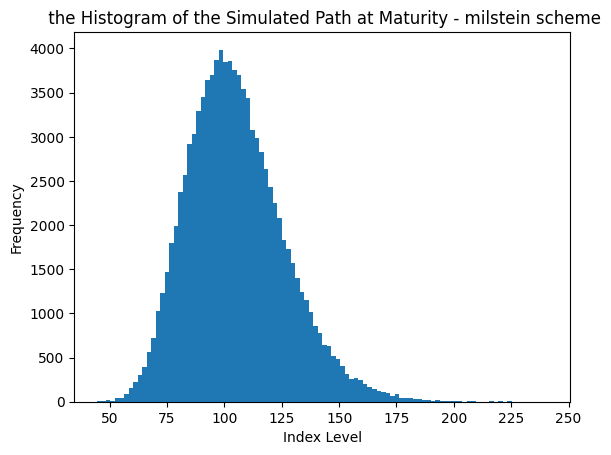

In [146]:
plt.hist(milsteinscheme.pathsimulation[-1,:], bins=100)
plt.title(' the Histogram of the Simulated Path at Maturity - milstein scheme')
plt.xlabel('Index Level')
plt.ylabel('Frequency')
plt.show()